In [16]:
import numpy as np
from CoolProp.CoolProp import PropsSI
import handcalcs.render
from handcalcs.decorator import handcalc
import pint
import endf
from numpy import pi
from numpy import sqrt, log, exp, log10
import os
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import fluids

ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
ureg.default_format = "~P"
Q_ = ureg.Quantity
ureg.define('USD = [currency] = $')

# Calculating the Heat Flux
The heat flux is used as a boundary condition in OpenFOAM, and can be calculated from the given pin geometry and the core power density

In [17]:
%%render
# Parameters
d_pin = 11.0*ureg('mm') # Pincell diameter
h = 3.0*ureg('m') # Active core height
R_pincell = (17.47/2)*ureg('mm') # Circumradius of hexagonal pincell
q_prime_prime_prime = 100.0*ureg('kW/L') # Voulmetric power density
t_clad = 0.6*ureg('mm') # Clad thickness

<IPython.core.display.Latex object>

In [18]:
%%render
r_pincell = sqrt(3)/2*R_pincell # Pincell inradius - the lattice pitch
A_fuel = pi*(d_pin/2 - t_clad)**2 # Fuel cross sectional area
A_subchannel = 2*sqrt(3)*r_pincell**2 -  pi*(d_pin/2)**2 # Coolant cross sectional area
q = A_fuel*h*q_prime_prime_prime # Power per rod
SA_pin = 2*pi*(d_pin/2)*h # Heated surface area of fuel pin
q_prime_prime = (q/SA_pin).to('W/m^2')

<IPython.core.display.Latex object>

Now, since we're not using chtMultiRegion, OpenFOAM doesn't have access to the thermal conductivity of the clad, which is necessary for determining the temperature gradient from the heat flux, so we must manually divide by $k$ to get the temperature gradient boundary at the clad surface

In [19]:
%%render
# Parameters
k_clad = 15.0*ureg('W/(m*K)')

<IPython.core.display.Latex object>

In [20]:
%%render
TempGradient = q_prime_prime/k_clad

<IPython.core.display.Latex object>

# Postprocessing
Paraview can calculate integrals over axial cross sections, but to calculate surface averaged quantities, we must manually divide by the area.

## Outlet Averaged Fields
We want to calculate the radial averages of the fields, $T$, $U_z$, and $p$. Paraview calculated the radial integrals of these quantities below

In [21]:
%%render
# Parameters
T_integrated = 0.0862743*ureg('K*m^2')
p_integrated = 3.9137*ureg('Pa*m^2')
U_z_integrated = 0.000102536*ureg('m/s*m^2')

<IPython.core.display.Latex object>

Now we divide by the cross sectional area of the coolant to get the radial average

In [22]:
%%render
T_avg = T_integrated/A_subchannel
U_z_avg = (U_z_integrated/A_subchannel).to('m/s')
p_avg = (p_integrated/A_subchannel).to('kPa')

<IPython.core.display.Latex object>

ASME Code Case N-201-5 provides for the use of Type 316H in core support structure applications at temperatures up to $816 C$, or $1089.15 K$, and we see that the maximum clad temperature of $940K$ is sufficiently below this code, allowing the use of stainless steel 316H.

## Radial Averaged Quantities

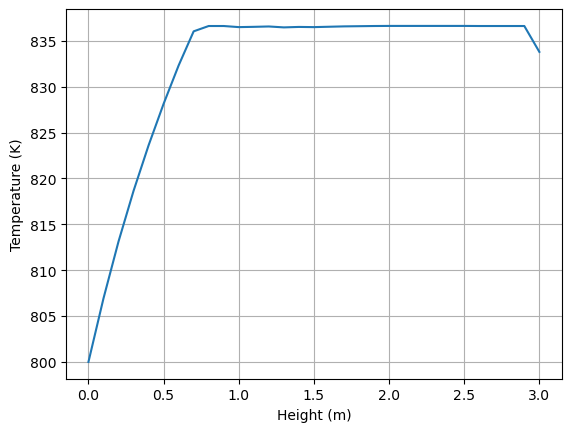

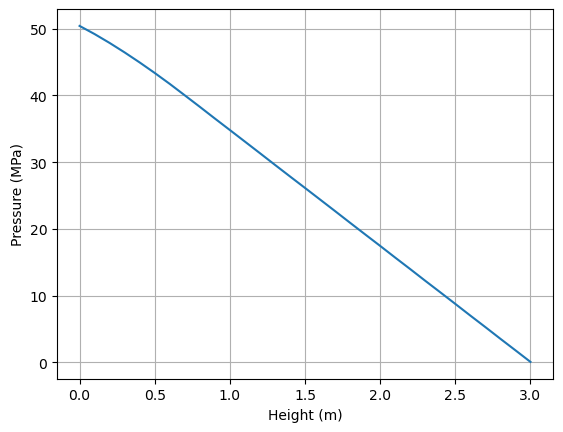

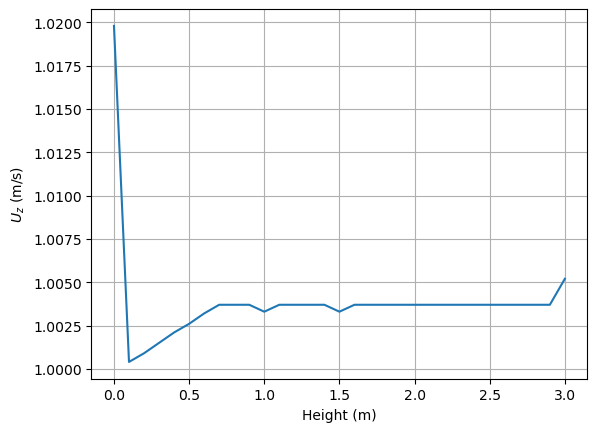

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('extracts/radial_averaged_data.csv')
data = df.to_dict(orient = 'list')

def plotFields(data):
    plt.figure(0)
    plt.plot(data['Z'], data['T'])
    plt.xlabel('Height (m)')
    plt.ylabel('Temperature (K)')
    plt.grid()

    plt.figure(1)
    plt.plot(data['Z'], np.array(data['p'])/1E+06)
    plt.xlabel('Height (m)')
    plt.ylabel('Pressure (MPa)')
    plt.grid()

    plt.figure(2)
    plt.plot(data['Z'], np.array(data['U:2']))
    plt.xlabel('Height (m)')
    plt.ylabel('$U_z$ (m/s)')
    plt.grid()

plotFields(data)

## Postprocess Axial Temperature Data For Fuel Case
The axial clad temperature data will be given as an input to the fuel temperature calculation, and it needs to be processed into a specific format.

In [24]:
list((index, temp) for index, temp in enumerate(data['T']))

[(0, 800.0),
 (1, 806.92),
 (2, 813.12),
 (3, 818.64),
 (4, 823.6),
 (5, 828.13),
 (6, 832.31),
 (7, 836.03),
 (8, 836.61),
 (9, 836.61),
 (10, 836.49),
 (11, 836.52),
 (12, 836.56),
 (13, 836.46),
 (14, 836.51),
 (15, 836.49),
 (16, 836.53),
 (17, 836.57),
 (18, 836.59),
 (19, 836.61),
 (20, 836.62),
 (21, 836.62),
 (22, 836.62),
 (23, 836.62),
 (24, 836.62),
 (25, 836.62),
 (26, 836.61),
 (27, 836.61),
 (28, 836.61),
 (29, 836.61),
 (30, 833.79)]

## Inner Surface Averaged Quantities

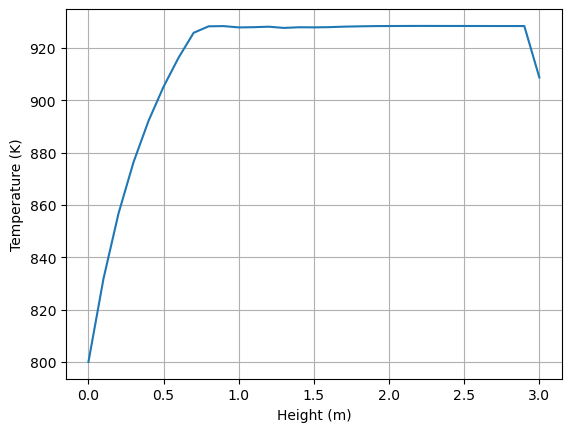

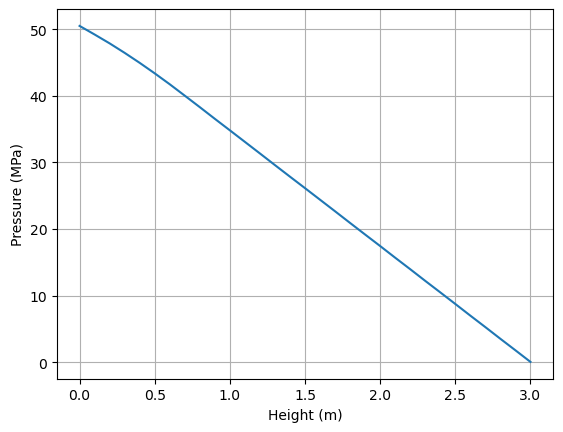

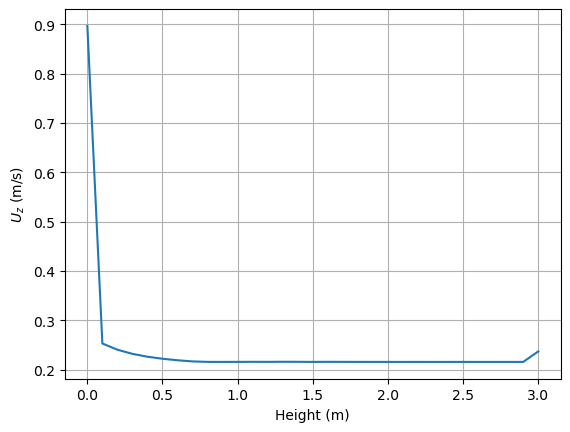

In [25]:
df = pd.read_csv('extracts/inner_surface_averaged_data.csv')
data = df.to_dict(orient = 'list')

plotFields(data)

# Worse Case: Fresh Core Hot Pin
For a completely fresh core (homogeneous), we may use diffusion theory to approximate the power peaking. For a finite cylinder, the flux is given by
\begin{equation}
    \phi(r,z) = AJ_0\left(\frac{2.405 r}{R}\right)\cos\left(\frac{\pi z}{H}\right)\nonumber
\end{equation}
And the minimum to average flux ratio is
\begin{equation}
    \frac{\phi_{max}}{\phi_{av}}\equiv \Omega = 3.64\nonumber
\end{equation}
so we can approximate that the central fuel element will produce 3.64 times the average pin power

In [26]:
%%render
P_pin_max = 3.64*q

<IPython.core.display.Latex object>

Really this is our limiting case, for which we need to calculate the clad temperature, but first it's worth scoping to see whether the case for the average fuel temperature would actually be viable for natural circulation, to do this we must analyze the entire primary loop.